# EECS 545 (WN 2025) Homework 2 Q1: Logistic Regression

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [30]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
# __NAME__ = "Honglak Lee"                                        #
# __UNIQID__ = "honglak"                                          #
###################################################################
__NAME__ = "Yichuan Zhang"                                        
__UNIQID__ = "yichuanz" 
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__ } <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Yichuan Zhang <yichuanz@umich.edu>


# Logistic Regression
In this notebook you will implement a Logistic Regression algorithm from a given dataset. 

Among various ways in computing gradient, this task will use Newton's Method for optimizing the weights.

After implementing the logistic regression, you will report the coefficients **w** and the plot.

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.11 or higher.

In [34]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [37]:
%load_ext autoreload
%autoreload 2

Once you located the `logistic_regression.py` correctly, run the following cell allow us to import from `logistic_regression.py`. If it works correctly, it should print the message:
```Hello from logistic_regression.py```

In [40]:
# install required libraries
# !pip install numpy==1.24.1 matplotlib==3.6.2 

from logistic_regression import hello
hello()

Hello from logistic_regression.py


Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [42]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# set figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [43]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

## Load the dataset
The following cell will load the dataset and show the dimension of each file. The two columns of `q1x.npy` represent the inputs ($x^{(i)}$) and `q1y.npy` represents the outputs $y^{(i)} \in \{ 0, 1 \}$, with one training example per row.

In [46]:
import os
import numpy as np
input_data = {}
for label, filename in [['X', 'data/q1x.npy'], ['Y', 'data/q1y.npy']]:
    if not os.path.exists(filename):
        raise Exception(f'Oops! We failed to find the data file {filename}')
    else:
        input_data[label] = np.load(filename)
        print(f'Load {filename} and stored it as {label}. The shape of the data is {input_data[label].shape}')
        print(f'First three rows looks like {input_data[label][:3]}')

Load data/q1x.npy and stored it as X. The shape of the data is (99, 2)
First three rows looks like [[ 1.3112952  -0.93399107]
 [ 1.4083846   1.726771  ]
 [ 0.97579413  1.3794301 ]]
Load data/q1y.npy and stored it as Y. The shape of the data is (99,)
First three rows looks like [0. 0. 0.]


Lets begin with adding 1's to the first dimension of X, so that we can handle intercept term at once. 

In [48]:
N = input_data['X'].shape[0]
input_data['X_new'] = np.concatenate((np.ones((N, 1)), input_data['X']), axis=1)

## Compute **w**: naive implementation

Now that we have prepared our data, it is time to implement Logistic Regression. We can first compute coefficients without vecterization. <span class="instruction">Implement the function `naive_logistic_regression` in `logistic_regression.py`.</span>

In [51]:
from logistic_regression import naive_logistic_regression
np.random.seed(0)

w_naive = naive_logistic_regression(input_data['X_new'], input_data['Y'])

print(w_naive.shape, w_naive)

(3,) [-1.84922892 -0.62814188  0.85846843]


## Compute **w**: vectorized implementation

When implementing algorithms, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside Numpy functions. This will usually be much faster than writing your own loops in Python, since Numpy functions can be internally optimized to iterate efficiently, possibly using multiple threads.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our naive function.

As a first step toward vectorizing our coefficient computation, you will implement a version that uses only a single Python loop over the training data. <span class="instruction">In the file `logistic_regression.py`, complete the implementation of the function `vectorized_logistic_regression`.</span>

We can check the correctness of our vectorized implementation by comparing it with our naive implementation over the data.

In [65]:
from logistic_regression import naive_logistic_regression
from logistic_regression import vectorized_logistic_regression
import numpy as np

np.random.seed(0)
w_naive = naive_logistic_regression(input_data['X_new'], input_data['Y'])

np.random.seed(0)
w_vec = vectorized_logistic_regression(input_data['X_new'], input_data['Y'])
print(w_vec.shape, w_vec)


difference = np.sqrt(((w_naive - w_vec)**2).sum())
print('Difference: ', difference)
if difference < 1e-4:
    print('Good! The two methods match in distance!')
else:
    raise Exception('Uh-oh! The two solutions are significantly different')

(3,) [-1.84922892 -0.62814188  0.85846843]
Difference:  4.710277376051325e-16
Good! The two methods match in distance!


We can now compare the speed of our implementations. If you've implemented everything properly, the vectorized implementation should take less than 1 seconds to run, and the naive implementation should take less than 10 seconds to run.

In [68]:
import time
from logistic_regression import naive_logistic_regression
from logistic_regression import vectorized_logistic_regression

def timeit(f, *args):
    tic = time.time()
    f(*args) 
    toc = time.time()
    return toc - tic

x_rand = np.random.randn(1000, 10)
y_rand = np.random.randint(2, size=1000)

naive_time = timeit(naive_logistic_regression, x_rand, y_rand)
print(f'Naive version took {naive_time:.2f} seconds')

vectorized_time = timeit(vectorized_logistic_regression, x_rand, y_rand)
speedup = naive_time / vectorized_time
print(f'Vectorized version took {vectorized_time:.2f} seconds ({speedup:.1f}X speedup)')

Naive version took 1.51 seconds
Vectorized version took 0.27 seconds (5.5X speedup)


## Plot the data and the coefficients

We can get some intuition of our logistic regression by visualizing its predictions. You will need to show the boundary separating the region where h(x) > 0.5 from where h(x) $\leq$ 0.5. <span class="instruction">In the file `logistic_regression.py`, implement the function `compute_y_boundary`. </span>

The following code will generate `logistic_regression.png` file as the final outcome. Please don't forget to attach the following figure to your report (writeup).

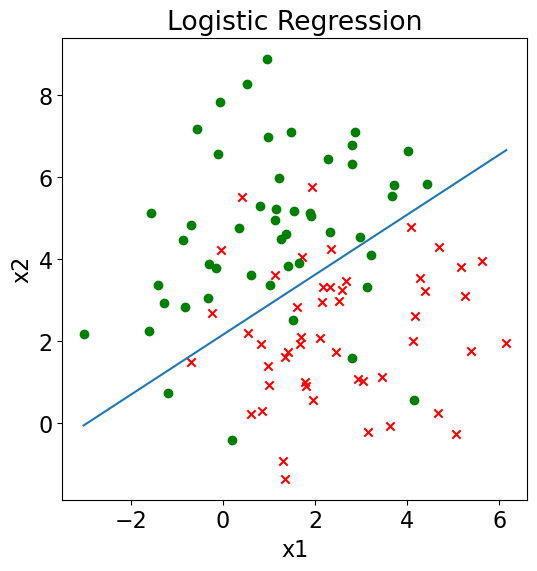

In [72]:
from logistic_regression import vectorized_logistic_regression
from logistic_regression import compute_y_boundary
import numpy as np

np.random.seed(0)
w = vectorized_logistic_regression(input_data['X_new'], input_data['Y'])

fig, ax = plt.subplots(figsize=(6, 6))
for x_i, y_i in zip(input_data['X_new'], input_data['Y']):
    if y_i == 0:
        ax.scatter(x=x_i[1], y=x_i[2], c='r', marker='x')
    else:
        ax.scatter(x=x_i[1], y=x_i[2], c='g', marker='o')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Logistic Regression')
        
x_coord = np.linspace(start=min(input_data['X_new'][:, 1]), 
                      stop=max(input_data['X_new'][:, 1]), num=50)
y_coord = compute_y_boundary(x_coord, w)

if y_coord is not None:
    ax.plot(x_coord, y_coord)

fig.savefig('logistic_regression.png', dpi=256)